# Fermion mean field

Mean-field states, including determinants and Pfaffians, are often the starting point in the study of fermionic systems. In this tutorial, we will introduce how to train these states in Quantax.

## Hubbard model

We utilize the 16x4 Hubbard model at 1/8 doping for illustration. As we will see, this system will exhibit stripe pattern, which is also observed in cuprates.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]='false'

import jax
import jax.numpy as jnp
import jax.random as jr
import quantax as qtx
import matplotlib.pyplot as plt

lattice = qtx.sites.Grid(
    (16, 4), particle_type=qtx.PARTICLE_TYPE.spinful_fermion, Nparticles=56
)

H = qtx.operator.Hubbard(U=3)

Here we choose interaction $U=3$, weaker than the usual strongly-correlated regime around $U=8$, because the optimization of mean-field states are unstable under strong interactions.

## Train mean-field determinant

The mean-field determinant state is defined as

$$
\ket{\psi_0} = \prod_\alpha \left(\sum_i U_{i\alpha} c_i^\dagger \right) \ket{0},
$$
where $U_{i\alpha}$ denotes trainable mean-field orbitals, and $i$ iterates over both spatial and spinful degrees of freedom.

In [12]:
det_state = qtx.state.GeneralDetState()

Then we can train it with gradient descent (GD) or Hartree-Fock (HF) self-consistency iteractions. In practice, it's most stable to train with GD first and then train with both.

-67.80696117587112


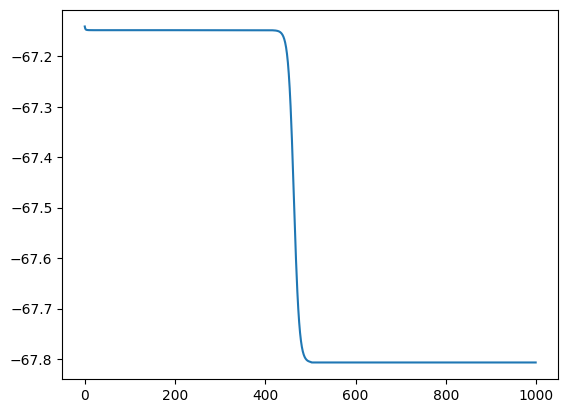

In [13]:
energy = qtx.utils.DataTracer()

for i in range(1000):
    step = det_state.get_step(H)
    det_state.update(step * 0.1)

    if i > 500:
        det_state.HF_update(H)

    energy.append(det_state.energy)

print(energy[-1])
energy.plot()
plt.show()

As the energy is computed exactly without stochastic error, one can also perform gradient descent with LBFGS to obtain better accuracy as shown below.

-67.80696117587112


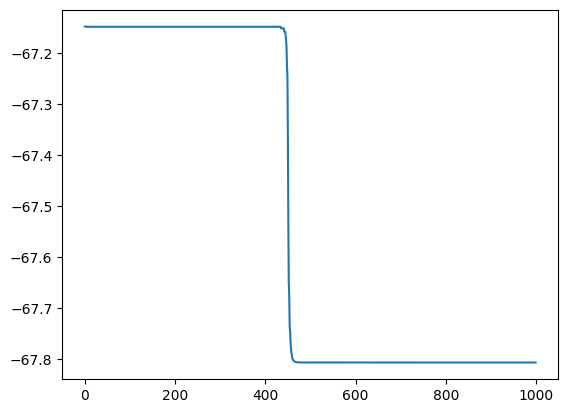

In [15]:
import equinox as eqx
from jaxopt import LBFGS

det_state = qtx.state.GeneralDetState()

params, static = eqx.partition(det_state.model, eqx.is_inexact_array)
def loss(params):
    model = eqx.combine(params, static)
    return det_state.expectation_from_model(model, H).real

solver = LBFGS(loss)
stat = solver.init_state(params)

energy = qtx.utils.DataTracer()

for i in range(1000):
    info = solver.update(params, stat)
    params = info.params
    stat = info.state
    E = stat.value
    energy.append(E)

print(energy[-1])
energy.plot()
plt.show()

## Measure observables

The mean-field states support quick measurement without Monte Carlso samples, as shown below.

In [8]:
E0 = det_state.expectation(H)
print(f"Mean-field energy: {E0}")

Mean-field energy: -67.80696117587114


The obtained energy is the final result in the training curve. We can also measure some other quantities, for example, charge and spin densities.

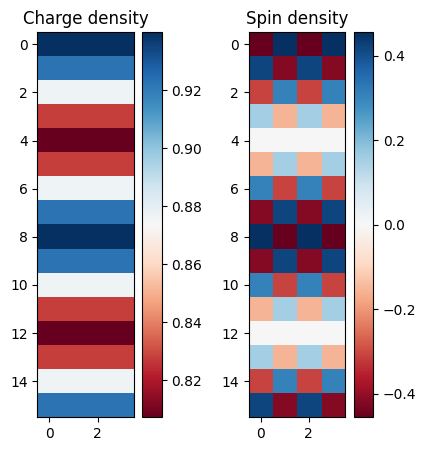

In [9]:
from quantax.operator import number_u, number_d

def charge(i):
    return (number_u(i) + number_d(i))

def spin(i):
    return (number_u(i) - number_d(i))

N = lattice.Nsites
i = lattice.index_from_xyz[0, 4, 2]
C = [det_state.expectation(charge(i)) for i in range(N)]
C = jnp.asarray(C).reshape(lattice.shape[1:]).real
S = [det_state.expectation(spin(i)) for i in range(N)]
S = jnp.asarray(S).reshape(lattice.shape[1:]).real

fig, axes = plt.subplots(1, 2, figsize=(5, 5))

axes[0].set_title("Charge density")
im = axes[0].imshow(C, cmap="RdBu")
fig.colorbar(im, ax=axes[0])
axes[1].set_title("Spin density")
im = axes[1].imshow(S, cmap="RdBu")
fig.colorbar(im, ax=axes[1])
plt.show()

We can see clear patterns of charge density wave and spin density wave. One can further measure the charge-charge and spin-spin correlations.

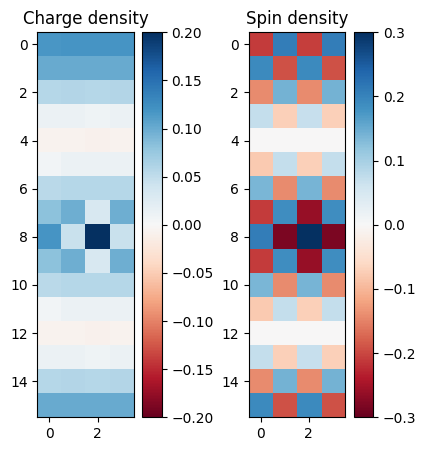

In [ ]:
def charge_correlation(i, j):
    return (number_u(i) + number_d(i)) * (number_u(j) + number_d(j))

def spin_correlation(i, j):
    return (number_u(i) - number_d(i)) * (number_u(j) - number_d(j))

i = lattice.index_from_xyz[0, 8, 2]
Cc = [det_state.expectation(charge_correlation(i, j)) for j in range(N)]
Cc = jnp.asarray(Cc).reshape(lattice.shape[1:]).real
Cc -= (lattice.Ntotal / N) ** 2
Sc = [det_state.expectation(spin_correlation(i, j)) for j in range(N)]
Sc = jnp.asarray(Sc).reshape(lattice.shape[1:]).real

fig, axes = plt.subplots(1, 2, figsize=(5, 5))

axes[0].set_title("Charge correlation")
im = axes[0].imshow(Cc, cmap="RdBu", vmin=-0.2, vmax=0.2)
fig.colorbar(im, ax=axes[0])
axes[1].set_title("Spin correlation")
im = axes[1].imshow(Sc, cmap="RdBu", vmin=-0.3, vmax=0.3)
fig.colorbar(im, ax=axes[1])
plt.show()